In [1]:
# ========================
# DenseNet121 - BRISC 2025 Classifier
# ========================

import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.applications.densenet import preprocess_input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
import matplotlib.pyplot as plt
import pickle

# === Data Augmentation ===
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    brightness_range=[0.8, 1.2],
    horizontal_flip=True,
    vertical_flip=False,
    validation_split=0.2,
    fill_mode='nearest'
)

train_generator = train_datagen.flow_from_directory(
    './archive/brisc2025/classification_task/train',
    target_size=(224, 224),
    color_mode='rgb',
    batch_size=32,
    class_mode='categorical',
    subset='training'
)

val_generator = train_datagen.flow_from_directory(
    './archive/brisc2025/classification_task/train',
    target_size=(224, 224),
    color_mode='rgb',
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)

test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
test_generator = test_datagen.flow_from_directory(
    './archive/brisc2025/classification_task/test',
    target_size=(224, 224),
    color_mode='rgb',
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

# === Callbacks ===
early_stop = EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=5, min_lr=1e-6)
checkpoint = ModelCheckpoint('./models/best_densenet121_model.h5', monitor='val_accuracy', save_best_only=True, verbose=1)

# === Base Model ===
base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze base layers
for layer in base_model.layers:
    layer.trainable = False

# === Custom Classifier ===
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.BatchNormalization(),
    layers.Dropout(0.4),
    layers.Dense(4, activation='softmax')
])

# === Compile ===
optimizer = Adam(learning_rate=1e-3)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# === Summary ===
model.summary()

# === Train ===
history = model.fit(
    train_generator,
    epochs=100,
    validation_data=val_generator,
    callbacks=[early_stop, reduce_lr, checkpoint]
)

Found 4002 images belonging to 4 classes.
Found 998 images belonging to 4 classes.
Found 1000 images belonging to 4 classes.


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ densenet121 (Functional)             │ (None, 7, 7, 1024)          │       7,037,504 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1024)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │         262,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 4)                   │           1,028 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 7,301,956 (27.85 MB)

 Trainable params: 263,940 (1.01 MB)

 Non-trainable params: 7,038,016 (26.85 MB)

C:\Users\Shaunak Mishra\Music\tensorfloww\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7232 - loss: 1.0803
Epoch 1: val_accuracy improved from None to 0.81563, saving model to ./models/best_densenet121_model.h5


126/126 ━━━━━━━━━━━━━━━━━━━━ 173s 1s/step - accuracy: 0.8138 - loss: 0.7646 - val_accuracy: 0.8156 - val_loss: 0.8461 - learning_rate: 0.0010
Epoch 2/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8764 - loss: 0.5378
Epoch 2: val_accuracy did not improve from 0.81563
126/126 ━━━━━━━━━━━━━━━━━━━━ 163s 1s/step - accuracy: 0.8758 - loss: 0.5243 - val_accuracy: 0.6924 - val_loss: 1.0117 - learning_rate: 0.0010
Epoch 3/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8857 - loss: 0.4769
Epoch 3: val_accuracy improved from 0.81563 to 0.83968, saving model to ./models/best_densenet121_model.h5


126/126 ━━━━━━━━━━━━━━━━━━━━ 168s 1s/step - accuracy: 0.8888 - loss: 0.4600 - val_accuracy: 0.8397 - val_loss: 0.7558 - learning_rate: 0.0010
Epoch 4/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 976ms/step - accuracy: 0.8924 - loss: 0.4348
Epoch 4: val_accuracy did not improve from 0.83968
126/126 ━━━━━━━━━━━━━━━━━━━━ 154s 1s/step - accuracy: 0.9018 - loss: 0.4120 - val_accuracy: 0.8327 - val_loss: 0.7649 - learning_rate: 0.0010
Epoch 5/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 997ms/step - accuracy: 0.9061 - loss: 0.3966
Epoch 5: val_accuracy did not improve from 0.83968
126/126 ━━━━━━━━━━━━━━━━━━━━ 156s 1s/step - accuracy: 0.9050 - loss: 0.4009 - val_accuracy: 0.7234 - val_loss: 1.0906 - learning_rate: 0.0010
Epoch 6/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9106 - loss: 0.3733
Epoch 6: val_accuracy improved from 0.83968 to 0.85471, saving model to ./models/best_densenet121_model.h5


126/126 ━━━━━━━━━━━━━━━━━━━━ 159s 1s/step - accuracy: 0.9093 - loss: 0.3782 - val_accuracy: 0.8547 - val_loss: 0.7200 - learning_rate: 0.0010
Epoch 7/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 981ms/step - accuracy: 0.9123 - loss: 0.3684
Epoch 7: val_accuracy did not improve from 0.85471
126/126 ━━━━━━━━━━━━━━━━━━━━ 155s 1s/step - accuracy: 0.9135 - loss: 0.3668 - val_accuracy: 0.8226 - val_loss: 0.7019 - learning_rate: 0.0010
Epoch 8/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9202 - loss: 0.3561
Epoch 8: val_accuracy improved from 0.85471 to 0.85671, saving model to ./models/best_densenet121_model.h5


126/126 ━━━━━━━━━━━━━━━━━━━━ 159s 1s/step - accuracy: 0.9128 - loss: 0.3686 - val_accuracy: 0.8567 - val_loss: 0.6678 - learning_rate: 0.0010
Epoch 9/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9164 - loss: 0.3505
Epoch 9: val_accuracy did not improve from 0.85671
126/126 ━━━━━━━━━━━━━━━━━━━━ 158s 1s/step - accuracy: 0.9185 - loss: 0.3408 - val_accuracy: 0.8337 - val_loss: 0.6944 - learning_rate: 0.0010
Epoch 10/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9271 - loss: 0.3195
Epoch 10: val_accuracy did not improve from 0.85671
126/126 ━━━━━━━━━━━━━━━━━━━━ 159s 1s/step - accuracy: 0.9235 - loss: 0.3240 - val_accuracy: 0.8317 - val_loss: 0.8139 - learning_rate: 0.0010
Epoch 11/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9169 - loss: 0.3197
Epoch 11: val_accuracy did not improve from 0.85671
126/126 ━━━━━━━━━━━━━━━━━━━━ 159s 1s/step - accuracy: 0.9158 - loss: 0.3216 - val_accuracy: 0.8046 - val_loss: 0.7650 - learning_rate: 0.0010
Epoch 12/100
126/

126/126 ━━━━━━━━━━━━━━━━━━━━ 211s 2s/step - accuracy: 0.9313 - loss: 0.2802 - val_accuracy: 0.8617 - val_loss: 0.6947 - learning_rate: 5.0000e-04
Epoch 17/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9265 - loss: 0.2930
Epoch 17: val_accuracy did not improve from 0.86172
126/126 ━━━━━━━━━━━━━━━━━━━━ 208s 2s/step - accuracy: 0.9210 - loss: 0.2944 - val_accuracy: 0.8577 - val_loss: 0.5168 - learning_rate: 5.0000e-04
Epoch 18/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9329 - loss: 0.2804
Epoch 18: val_accuracy improved from 0.86172 to 0.87675, saving model to ./models/best_densenet121_model.h5


126/126 ━━━━━━━━━━━━━━━━━━━━ 208s 2s/step - accuracy: 0.9298 - loss: 0.2836 - val_accuracy: 0.8768 - val_loss: 0.5918 - learning_rate: 5.0000e-04
Epoch 19/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9216 - loss: 0.2791
Epoch 19: val_accuracy did not improve from 0.87675
126/126 ━━━━━━━━━━━━━━━━━━━━ 194s 2s/step - accuracy: 0.9250 - loss: 0.2753 - val_accuracy: 0.8697 - val_loss: 0.6331 - learning_rate: 5.0000e-04
Epoch 20/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9249 - loss: 0.2825
Epoch 20: val_accuracy did not improve from 0.87675
126/126 ━━━━━━━━━━━━━━━━━━━━ 163s 1s/step - accuracy: 0.9240 - loss: 0.2805 - val_accuracy: 0.8537 - val_loss: 0.6095 - learning_rate: 5.0000e-04
Epoch 21/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9371 - loss: 0.2671
Epoch 21: val_accuracy did not improve from 0.87675
126/126 ━━━━━━━━━━━━━━━━━━━━ 160s 1s/step - accuracy: 0.9338 - loss: 0.2648 - val_accuracy: 0.8687 - val_loss: 0.6280 - learning_rate: 5.0000e-04

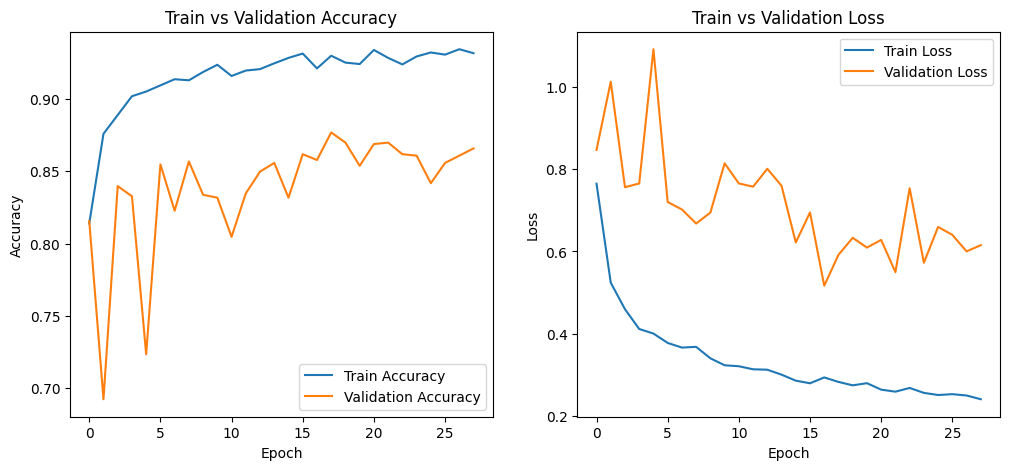

In [2]:
import matplotlib.pyplot as plt

# Accuracy plot
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Train vs Validation Accuracy')
plt.legend()

# Loss plot
plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train vs Validation Loss')
plt.legend()

plt.show()


In [3]:
import numpy as np

# Predict probabilities
y_pred_probs = model.predict(test_generator)

# Convert to class indices
y_pred = np.argmax(y_pred_probs, axis=1)

# True labels
y_true = test_generator.classes


32/32 ━━━━━━━━━━━━━━━━━━━━ 31s 921ms/step


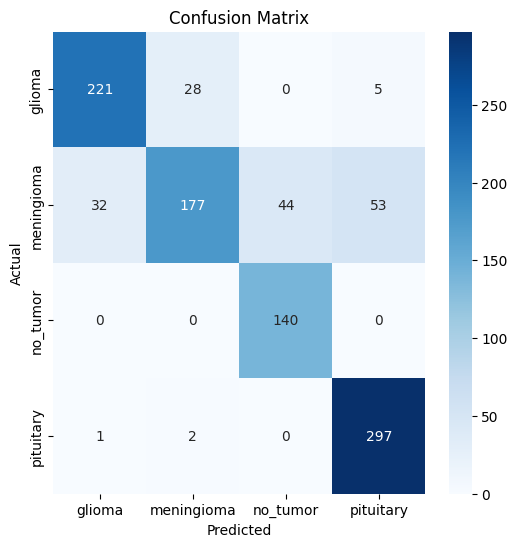

In [4]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(6,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=test_generator.class_indices.keys(), yticklabels=test_generator.class_indices.keys())
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [5]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')

print(f'Test Accuracy: {accuracy*100:.2f}%')
print(f'Test Precision: {precision*100:.2f}%')
print(f'Test Recall: {recall*100:.2f}%')
print(f'Test F1 Score: {f1*100:.2f}%')

# Detailed per-class report
print("\nClassification Report:\n")
print(classification_report(y_true, y_pred, target_names=list(test_generator.class_indices.keys())))

Test Accuracy: 83.50%
Test Precision: 84.02%
Test Recall: 83.50%
Test F1 Score: 82.52%

Classification Report:

              precision    recall  f1-score   support

      glioma       0.87      0.87      0.87       254
  meningioma       0.86      0.58      0.69       306
    no_tumor       0.76      1.00      0.86       140
   pituitary       0.84      0.99      0.91       300

    accuracy                           0.83      1000
   macro avg       0.83      0.86      0.83      1000
weighted avg       0.84      0.83      0.83      1000

